# Deep learning pipeline for Parkinson’s disease detection using spectrogram images and ResNet18 as a classifier with audio augmentation

In [24]:
# Step 1: Install dependencies
!pip install torchaudio librosa datasets torchvision --quiet

In [25]:
# Step 2: Import libraries
import os
import torch
import torchaudio
import librosa
import numpy as np
import matplotlib.pyplot as plt
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
from datasets import load_dataset
from PIL import Image
from sklearn.model_selection import StratifiedKFold, GroupKFold
from collections import Counter
import random
import time

In [26]:
# Step 3: Mel spectrogram and augmentation
def augment_audio(audio, sr):
    noise = 0.005 * np.random.randn(len(audio))
    audio += noise
    audio = librosa.effects.time_stretch(audio, rate=np.random.uniform(0.9, 1.1))
    audio = librosa.effects.pitch_shift(audio, sr=sr, n_steps=np.random.uniform(-1, 1))
    return audio

def audio_to_mel_spectrogram(audio, sr, n_mels=128):
    S = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=n_mels)
    S_DB = librosa.power_to_db(S, ref=np.max)
    return S_DB

In [27]:
# Step 4: Dataset class
class PDDataset(Dataset):
    def __init__(self, data, indices, transform=None, augment=False):
        self.data = [data[i] for i in indices]
        self.transform = transform
        self.augment = augment

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        audio = sample['audio']['array']
        sr = sample['audio']['sampling_rate']
        file_path = sample['audio']['path']
        label = sample['label']
        if self.augment:
            audio = augment_audio(audio, sr)
        mel_spec = audio_to_mel_spectrogram(audio, sr)
        mel_spec = (mel_spec - mel_spec.min()) / (mel_spec.max() - mel_spec.min()) * 255
        mel_spec = mel_spec.astype(np.uint8)
        img = Image.fromarray(mel_spec).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, torch.tensor(label, dtype=torch.long)

In [30]:
# Step 5: Load and preprocess dataset with grouping
raw_dataset = load_dataset("birgermoell/Italian_Parkinsons_Voice_and_Speech", split="train")
preprocessed = []
labels = []
groups = []   # group by speaker/session
bad_paths = []

for sample in raw_dataset:
    path = sample['audio']['path']
    lower_path = path.lower()
    # Exclude non-audio files
    if ".zip" in lower_path or ".xlsx" in lower_path:
        continue
    # Label assignment
    if "healthy" in lower_path or "control" in lower_path or "hc" in lower_path:
        label = 0
    elif "parkinson" in lower_path or "disease" in lower_path or "pd" in lower_path:
        label = 1
    else:
        bad_paths.append(path)
        continue
    # Speaker/session extraction (modify if your structure is different)
    # Example: path = ".../Speaker1/sessionX/rec.wav"
    # Assuming the speaker is the first part of the file name:
    speaker = os.path.basename(path).split('_')[0]
    #speaker = path.split('/')[2] if len(path.split('/')) > 2 else path  # Change index if your speaker is in another part
    preprocessed.append({'audio': sample['audio'], 'label': label, 'speaker': speaker, 'path': path})
    labels.append(label)
    groups.append(speaker)

print("Label distribution:", Counter(labels))
if bad_paths:
    print("Unrecognized/Skipped files:")
    for p in bad_paths:
        print(" ", p)

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

Resolving data files:   0%|          | 0/833 [00:00<?, ?it/s]

Label distribution: Counter({1: 421, 0: 410})


In [31]:
# Step 6: GroupKFold (no speaker/session in both train & test)
k_folds = 5
gkf = GroupKFold(n_splits=k_folds)
all_y_true, all_y_pred = [], []

for fold, (train_idx, test_idx) in enumerate(gkf.split(preprocessed, labels, groups), 1):
    print(f"\nFold {fold}/{k_folds}")

    train_dataset = PDDataset(preprocessed, train_idx, transform=transform, augment=True)
    test_dataset = PDDataset(preprocessed, test_idx, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=16)

    # Define model
    model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
    num_ftrs = model.fc.in_features
    model.fc = torch.nn.Sequential(
        torch.nn.Dropout(0.5),
        torch.nn.Linear(num_ftrs, 2)
    )
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

    # Training
    for epoch in range(5):
        model.train()
        train_loss, correct, total = 0, 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        print(f"Epoch {epoch+1}, Training Loss: {train_loss/len(train_loader):.4f}, Training Accuracy: {100 * correct / total:.2f}%")

    # Evaluation
    model.eval()
    test_loss, test_correct, test_total = 0, 0, 0
    y_true, y_pred = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()
    all_y_true.extend(y_true)
    all_y_pred.extend(y_pred)
    print(f"Test Loss: {test_loss/len(test_loader):.4f}, Test Accuracy: {100 * test_correct / test_total:.2f}%")


Fold 1/5
Epoch 1, Training Loss: 0.4103, Training Accuracy: 80.42%
Epoch 2, Training Loss: 0.1710, Training Accuracy: 93.83%
Epoch 3, Training Loss: 0.1058, Training Accuracy: 96.54%
Epoch 4, Training Loss: 0.0863, Training Accuracy: 97.14%
Epoch 5, Training Loss: 0.1237, Training Accuracy: 95.63%
Test Loss: 0.6527, Test Accuracy: 73.05%

Fold 2/5
Epoch 1, Training Loss: 0.4055, Training Accuracy: 80.75%
Epoch 2, Training Loss: 0.1569, Training Accuracy: 94.14%
Epoch 3, Training Loss: 0.1224, Training Accuracy: 95.49%
Epoch 4, Training Loss: 0.0867, Training Accuracy: 97.44%
Epoch 5, Training Loss: 0.0734, Training Accuracy: 97.74%
Test Loss: 0.3774, Test Accuracy: 86.14%

Fold 3/5
Epoch 1, Training Loss: 0.4344, Training Accuracy: 80.00%
Epoch 2, Training Loss: 0.1418, Training Accuracy: 95.19%
Epoch 3, Training Loss: 0.1572, Training Accuracy: 94.14%
Epoch 4, Training Loss: 0.0845, Training Accuracy: 96.69%
Epoch 5, Training Loss: 0.0697, Training Accuracy: 97.44%
Test Loss: 0.0651,

In [32]:
from sklearn.metrics import classification_report, confusion_matrix

print("\nClassification Report (All Folds):")
print(classification_report(all_y_true, all_y_pred, target_names=["HC", "PD"]))
print("Confusion Matrix:")
print(confusion_matrix(all_y_true, all_y_pred))


Classification Report (All Folds):
              precision    recall  f1-score   support

          HC       0.98      0.80      0.88       410
          PD       0.84      0.99      0.91       421

    accuracy                           0.90       831
   macro avg       0.91      0.89      0.89       831
weighted avg       0.91      0.90      0.89       831

Confusion Matrix:
[[328  82]
 [  5 416]]


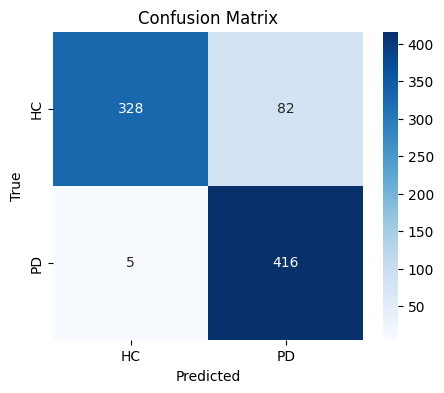

In [33]:
# Plot Confusion Matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming all_y_true and all_y_pred contain your test labels and predictions
cm = confusion_matrix(all_y_true, all_y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['HC','PD'], yticklabels=['HC','PD'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

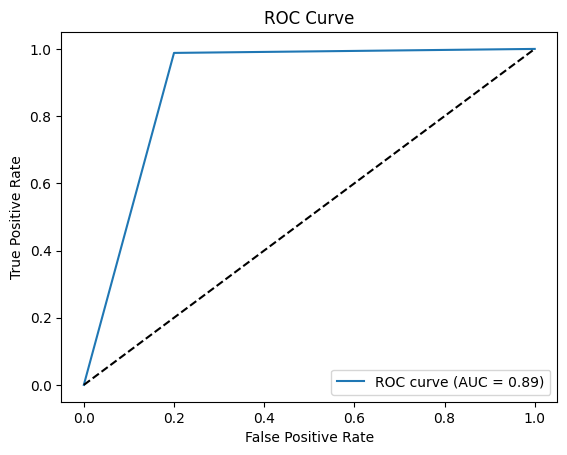

In [34]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(all_y_true, all_y_pred)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()